In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tkinter as tk
from tkinter import messagebox
import folium
import webbrowser
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data = pd.read_csv('../data/new_arabic_dialect_dataset.csv')
data = data.fillna('')
data

,sentence,dialect,sentence_clean
0,ياخي المدرب أختاره والمدرب دخله والمدرب بارك ا...,AE,ياخي المدرب أختاره والمدرب دخله والمدرب بارك ا...
1,شو الي قاعد يجري فالنصر يا أخوه خسر المباراة س...,AE,شو قاعد يجري فالنصر يا أخوه خسر المباراة سقطة ...
2,الي يبحث عن مشكلة الوصل راح يحصلها فالجولان,AE,يبحث عن مشكلة الوصل راح يحصلها فالجولان
3,انا مش معترض على تغير عامر الي دخل مكان عامر ا...,AE,مش معترض تغير عامر دخل مكان عامر المفترض ريان ...
4,تراجع مخيف في مستوى الحارس الكبير ماجد ناصر مش...,AE,تراجع مخيف مستوى الحارس الكبير ماجد ناصر مش ما...
...,...,...,...
365714,هل لك أن تسمح بالتقاط صورة لك معنا,MSA,هل لك أن تسمح بالتقاط صورة لك معنا
365715,هل لديك سمك مقلي,MSA,هل لديك سمك مقلي
365716,هل يمكني استئجار مرشدا يتحدث الغة اليابانية,MSA,هل يمكني استئجار مرشدا يتحدث الغة اليابانية
365717,أيهما تعتقد أنها أفضل كهدية لصبي عمره ثماني سنوات,MSA,أيهما تعتقد أنها أفضل كهدية لصبي عمره ثماني سنوات


In [3]:
X = data.sentence_clean
y = data.dialect
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=data['dialect'])
print(X_train)

113894          ودي اعرف جد شنو استفاده او ونسته الحركه فيه
239937    شعب نصه محش ونصه سكران اشلون بتقدر المرأه تسوق...
81704     استشهادالكاظمالمسموم وبعض الشباب رايحين لونسة ...
269611                            وايش الناس وايش الناس مني
72264     يا تري بيعيش الزمن إحنا ولا الزمن بيعشنا القاء...
                                ...                        
335959                                    ياخي هذا روج لافر
295786                         تو هذا سؤال تي مو خاطرو غراب
288485    واله كلامك العين والراس يا ناصر انتهاكات بالجم...
73245                وخصوصا فى يوم الجمعه فيها ساعة استجابه
191319    الثلاثاء الشركة البترولية البريطانية فرص عمل و...
Name: sentence_clean, Length: 292575, dtype: object


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.model_selection import StratifiedKFold

vectorizer_tfidf = TfidfVectorizer()
classifier_tfidf_NB = MultinomialNB()

model_tfidf_NB = Pipeline([
    ("vectorizer", vectorizer_tfidf),
    ("scaler", StandardScaler(with_mean=False)),
    ("classifier", classifier_tfidf_NB)
])

param_grid = {
    "vectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)],
    "classifier__alpha": [0.1, 1, 10]
}

# Perform grid search with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(model_tfidf_NB, param_grid, cv=cv, scoring="accuracy")
grid_search.fit(X_train, y_train)


0.43375202939417246

In [13]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(best_params)
print(best_score)

{'classifier__alpha': 10, 'vectorizer__ngram_range': (1, 2)}
0.43375202939417246


In [8]:
# Fit the model with the best parameters
model_tfidf_NB.set_params(**best_params)
model_tfidf_NB.fit(X_train, y_train)

# Save the model
joblib.dump(model_tfidf_NB, '../models/model_tfidf_NB.pkl')

['../models/model_tfidf_NB.pkl']

In [9]:
from sklearn.metrics import accuracy_score

saved_model_tfidf_NB = joblib.load('../models/model_tfidf_NB.pkl')

predicted_train_tfidf_NB = saved_model_tfidf_NB.predict(X_train)
accuracy_train_tfidf_NB = accuracy_score(y_train, predicted_train_tfidf_NB)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf_NB))

predicted_test_tfidf_NB = model_tfidf_NB.predict(X_test)
accuracy_test_tfidf_NB = accuracy_score(y_test, predicted_test_tfidf_NB)
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf_NB))

Accuracy Training data: 99.5%
Accuracy Test data: 44.4%


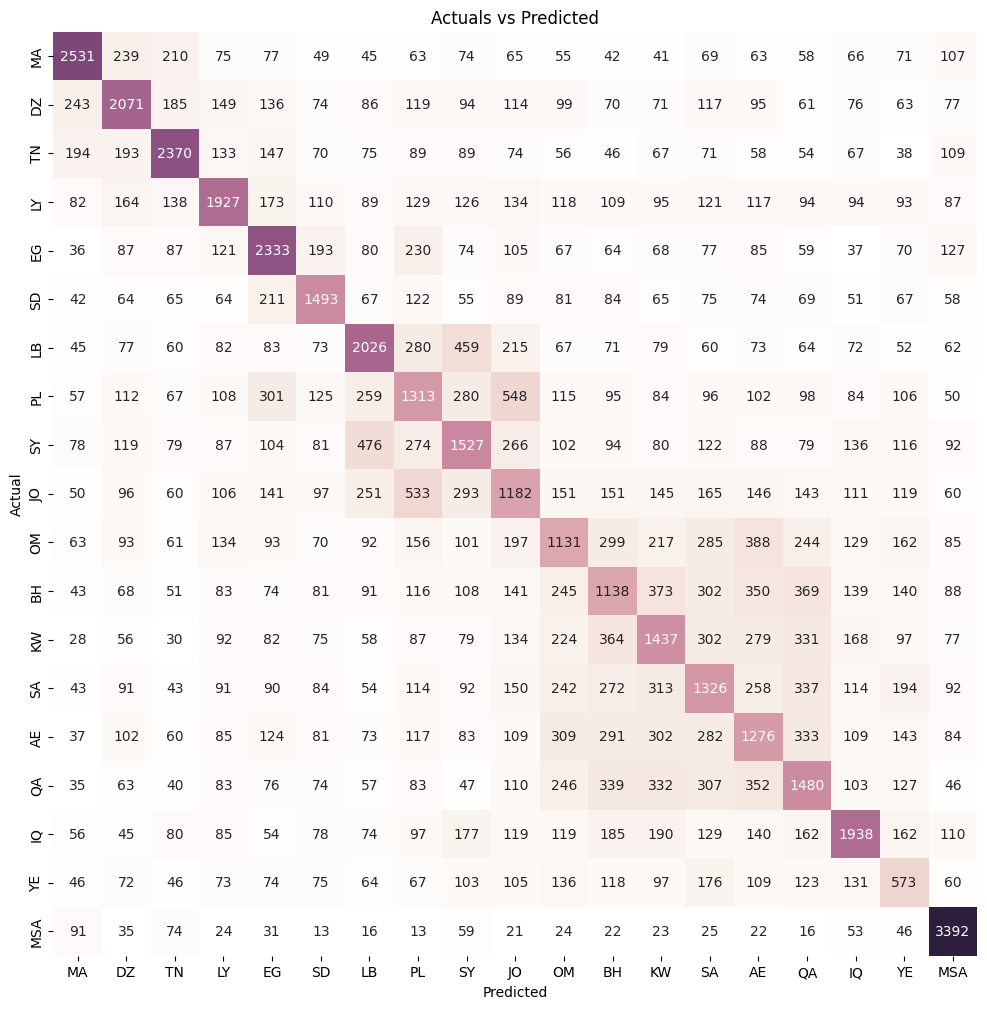

In [10]:
from sklearn.metrics import confusion_matrix

data = confusion_matrix(y_test, predicted_test_tfidf_NB,labels=["MA", "DZ","TN","LY","EG","SD","LB","PL","SY","JO","OM","BH","KW","SA","AE","QA","IQ","YE","MSA"])
data_cm = pd.DataFrame(data, columns=["MA", "DZ","TN","LY","EG","SD","LB","PL","SY","JO","OM","BH","KW","SA","AE","QA","IQ","YE","MSA"], index = ["MA", "DZ","TN","LY","EG","SD","LB","PL","SY","JO","OM","BH","KW","SA","AE","QA","IQ","YE","MSA"])
data_cm.index.name = 'Actual'
data_cm.columns.name = 'Predicted'


f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

sns.heatmap(data_cm, cbar=False, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size':10})
plt.title('Actuals vs Predicted')
plt.show()

In [ ]:
def get_country_coordinates(country,proximity_score):
    # Define a dictionary with the latitude and longitude coordinates for each Arabic country
    country_coordinates = {
        "MA": [31.7917, -7.0926],
        "DZ": [36.7538, 3.0588],
        "TN": [33.8869, 9.5375],
        "LY": [26.3351, 17.2283],
        "EG": [26.8206, 30.8025],
        "SD": [15.5007, 32.5599],
        "LB": [33.8547, 35.8623],
        "PL": [33.8547, 35.8623],
        "SY": [34.8021, 38.9968],
        "JO": [30.5852, 36.2384],
        "OM": [21.4735, 55.9754],
        "BH": [26.0667, 50.5577],
        "KW": [29.3117, 47.4818],
        "SA": [23.8859, 45.0792],
        "AE": [23.4241, 53.8478],
        "QA": [25.3548, 51.1839],
        "IQ": [33.2232, 43.6793],
        "YE": [15.5527, 48.5164]
        "MSA": [24.0000, 45.0000]  # Placeholder coordinates for MSA
    }
    
    # Define the gradient colors from yellow to red
    colors = ["yellow", "red"]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

    # Map the proximity score to the gradient colormap
    color = cmap(proximity_score)

    return country_coordinates.get(country, [0, 0]), color

In [ ]:
def predict_dialect():
    sentence = entry.get()

    if sentence.strip() == '':
        messagebox.showerror("Error", "Please enter an Arabic sentence.")
        return

    prediction = model_tfidf_NB.predict([sentence])
    probabilities = model_tfidf_NB.predict_proba([sentence])[0]

    result = f"The predicted dialect is: {prediction}\n"
    result += "Prediction probabilities for each dialect:\n"
    for dialect, probability in zip(model_tfidf_NB.classes_, probabilities):
        result += f"{dialect}: {probability:.4f}\n"
        
        # Create a map centered around Arabic countries
    m = folium.Map(location=[24, 43], zoom_start=4)

    # Add a marker for the predicted dialect country
    predicted_country = prediction[0]
    folium.Marker(location=get_country_coordinates(predicted_country, 0)[0],
                  popup=f"Predicted: {predicted_country}",
                  icon=folium.Icon(color='green', icon='info-sign')).add_to(m)

    # Add heatmap layers for each Arabic country
    for dialect, probability in zip(model_tfidf_NB.classes_, probabilities):
        proximity_score = 1 - probability  # Calculate the proximity score
        coordinates, color = get_country_coordinates(dialect, proximity_score)  # Get coordinates and color
        folium.CircleMarker(location=coordinates,
                            radius=10,
                            color='rgb{}'.format(color),
                            fill=True,
                            fill_color='rgb{}'.format(color),
                            fill_opacity=0.7).add_to(m)

    # Save the map as an HTML file
    map_file = 'heatmap.html'
    m.save(map_file)

    # Open the HTML file in a web browser
    webbrowser.open(map_file)

    messagebox.showinfo("Prediction", result)

In [ ]:
root = tk.Tk()
root.title("Arabic Dialect Predictor")

label = tk.Label(root, text="Enter an Arabic sentence:")
label.pack()

entry = tk.Entry(root, width=50)
entry.pack()

button = tk.Button(root, text="Predict", command=predict_dialect)
button.pack()

root.mainloop()